In [99]:
import pandas as pd
from datetime import datetime
from darts import TimeSeries
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
from scipy import stats

In [4]:
data_path = 'db.csv'

In [5]:
df = pd.read_csv(f'{data_path}', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64765 entries, 0 to 64764
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Billing date       64765 non-null  int64 
 1   Material           64765 non-null  int64 
 2   Phisical quantity  64765 non-null  int64 
 3   Country            64765 non-null  int64 
 4   Net price          64765 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.5+ MB


In [6]:
df.head(10)

,Billing date,Material,Phisical quantity,Country,Net price
0,10052022,1795,10,7511,"2,865"
1,10052022,1778,5,7511,"0,66375"
2,10052022,1778,15,7511,"0,66375"
3,10052022,9526,4,7511,"36,31125"
4,10052022,1778,11,7511,"0,66375"
5,10052022,1778,15,7511,"0,66375"
6,10052022,1778,5,7511,"0,66375"
7,10052022,2844,2,7511,"35,185"
8,10052022,4151,6,7511,"31,47875"
9,10052022,2844,2,7511,"35,185"


## Análisis exploratorio

In [16]:
df2 = pd.DataFrame(data={
    "Material": [2,3,4,5,6,10],
    "count": [20,30,45,53,65,100]
}, columns=['Material', 'count'])

In [20]:
df['Phisical quantity'] = df['Phisical quantity'].astype(int)

### Creamos una columna de fecha

In [25]:
def process_date_str(number):
    string = str(number)
    if len(string) == 7:
        string = '0' + string
    return f'{string[4:]}-{string[2:4]}-{string[:2]}'

In [26]:
df['time_str'] = df['Billing date'].apply(process_date_str)
df['time'] = pd.to_datetime(df['time_str'], format='%Y-%m-%d')
df

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
0,10052022,1795,10,7511,"2,865",2022-05-10,2022-05-10
1,10052022,1778,5,7511,"0,66375",2022-05-10,2022-05-10
2,10052022,1778,15,7511,"0,66375",2022-05-10,2022-05-10
3,10052022,9526,4,7511,"36,31125",2022-05-10,2022-05-10
4,10052022,1778,11,7511,"0,66375",2022-05-10,2022-05-10
...,...,...,...,...,...,...,...
64760,30042024,1634,100,1526,"2,5175",2024-04-30,2024-04-30
64761,30042024,1634,2,1526,"2,5175",2024-04-30,2024-04-30
64762,30042024,1634,60,1526,"2,5175",2024-04-30,2024-04-30
64763,30042024,1679,2,1526,"29,5575",2024-04-30,2024-04-30


## Agrupacion de ventas

In [27]:
first_sale = df['time'].min()
first_sale

Timestamp('2018-08-24 00:00:00')

In [28]:
last_sale = df['time'].max()
last_sale

Timestamp('2024-09-26 00:00:00')

In [29]:
def string_format(agg):
    if agg == 'yearly':
        return 'year', '%Y'
    elif agg == 'monthly':
        return 'year_month', '%Y%m'
    elif agg == 'daily':
        return 'year_month_day', '%Y%m%d'
    elif agg == 'hourly':
        return 'year_month_day_hour', '%Y%m%d %H'
    else:
        raise Exception(f'Invalid aggregation type: {agg}')

### Agrupación de ventas por ítem

Vemos la cantidad de ventas por ítem

In [124]:
most_sold_items_df = df.groupby('Material').count().reset_index()[['Material', 'Phisical quantity']].sort_values(by='Phisical quantity', ascending=False)
first_n_sold_items = most_sold_items_df['Material'].tolist()[:5]

In [127]:
less_sold_items_df = df.groupby('Material').count().reset_index()[['Material', 'Phisical quantity']].sort_values(by='Phisical quantity', ascending=False)
last_n_sold_items = less_sold_items_df['Material'].tolist()[:10]

In [128]:
first_n_sold_items

[1872, 4488, 3224, 2489, 6633]

In [129]:
last_n_sold_items

[1872, 4488, 3224, 2489, 6633, 3628, 1979, 1384, 9126, 1524]

Tomamos el material de ID `1872` que tiene un total de 375 ventas en total

In [130]:
material_id = first_n_sold_items[0]

#### Agrupación mensual

In [131]:
col_name, _string_format = string_format('monthly')

df[col_name] = df['time'].apply(lambda x: x.strftime(_string_format))
df['time_trunc'] = df['time'].to_numpy().astype('datetime64[M]')
df['time_trunc'] = pd.to_datetime(df['time_trunc'], format='%Y-%m-%d')
df

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time,year_month,time_trunc,z_score
0,10052022,1795,10,7511,"2,865",2022-05-10,2022-05-10,202205,2022-05-01,-0.155910
1,10052022,1778,5,7511,"0,66375",2022-05-10,2022-05-10,202205,2022-05-01,-0.182398
2,10052022,1778,15,7511,"0,66375",2022-05-10,2022-05-10,202205,2022-05-01,-0.129421
3,10052022,9526,4,7511,"36,31125",2022-05-10,2022-05-10,202205,2022-05-01,-0.187696
4,10052022,1778,11,7511,"0,66375",2022-05-10,2022-05-10,202205,2022-05-01,-0.150612
...,...,...,...,...,...,...,...,...,...,...
64760,30042024,1634,100,1526,"2,5175",2024-04-30,2024-04-30,202404,2024-04-01,0.320883
64761,30042024,1634,2,1526,"2,5175",2024-04-30,2024-04-30,202404,2024-04-01,-0.198292
64762,30042024,1634,60,1526,"2,5175",2024-04-30,2024-04-30,202404,2024-04-01,0.108975
64763,30042024,1679,2,1526,"29,5575",2024-04-30,2024-04-30,202404,2024-04-01,-0.198292


In [132]:
# Filtramos por el ítem y calculamos la distribución mensual de ventas
agg_df = df.groupby(['Material', 'time_trunc']).count()[['Phisical quantity']].reset_index()
agg_df

,Material,time_trunc,Phisical quantity
0,1002,2019-06-01,1
1,1002,2020-08-01,1
2,1002,2021-02-01,1
3,1002,2021-03-01,2
4,1002,2021-04-01,2
...,...,...,...
35934,9998,2022-07-01,7
35935,9998,2022-09-01,1
35936,9998,2023-01-01,2
35937,9998,2023-08-01,1


### Calculo de outliers

In [139]:
filtered_df = agg_df[agg_df.Material.isin(last_n_sold_items)]
filtered_df

,Material,time_trunc,Phisical quantity
1282,1384,2018-08-01,2
1283,1384,2018-09-01,1
1284,1384,2018-10-01,5
1285,1384,2018-11-01,4
1286,1384,2018-12-01,5
...,...,...,...
32537,9126,2024-05-01,15
32538,9126,2024-06-01,3
32539,9126,2024-07-01,2
32540,9126,2024-08-01,4


In [140]:
filtered_df['z_score'] = stats.zscore(filtered_df['Phisical quantity'])

/var/folders/5x/tlp5fd614dv9y_wn8nmtqv4rqq_frn/T/ipykernel_72685/2004188341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['z_score'] = stats.zscore(filtered_df['Phisical quantity'])


In [141]:
threshold = 3
outliers = filtered_df[filtered_df['z_score'].abs() >= threshold]
outliers

,Material,time_trunc,Phisical quantity,z_score
1315,1384,2022-03-01,14,3.209772
3451,1872,2019-08-01,18,4.529853
3473,1872,2021-07-01,15,3.539792
3484,1872,2022-07-01,15,3.539792
3988,1979,2022-10-01,16,3.869813
6279,2489,2022-05-01,18,4.529853
22864,6633,2022-05-01,16,3.869813
22883,6633,2024-03-01,19,4.859873
32520,9126,2022-07-01,14,3.209772
32537,9126,2024-05-01,15,3.539792


In [142]:
filtered_df

,Material,time_trunc,Phisical quantity,z_score
1282,1384,2018-08-01,2,-0.750471
1283,1384,2018-09-01,1,-1.080492
1284,1384,2018-10-01,5,0.239590
1285,1384,2018-11-01,4,-0.090431
1286,1384,2018-12-01,5,0.239590
...,...,...,...,...
32537,9126,2024-05-01,15,3.539792
32538,9126,2024-06-01,3,-0.420451
32539,9126,2024-07-01,2,-0.750471
32540,9126,2024-08-01,4,-0.090431


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

Text(0.5, 1.0, 'Ventas mensuales 10 ítems menos vendidos')

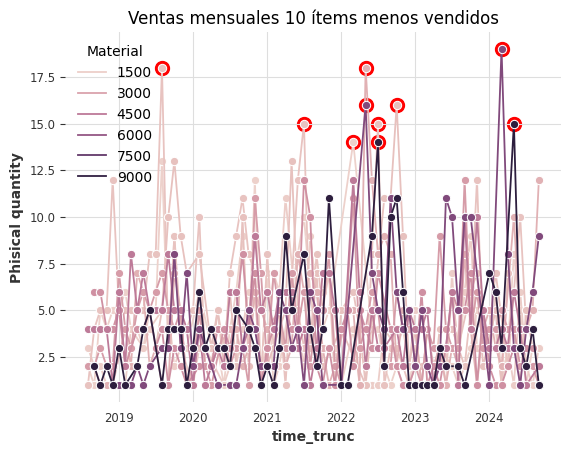

In [145]:
ax = sns.lineplot(data=filtered_df, x='time_trunc', y='Phisical quantity', marker='o', hue='Material')
plt.scatter(outliers['time_trunc'], outliers['Phisical quantity'], color='red', label='Outliers', s=100)
ax.set_title(f'Ventas mensuales {len(last_n_sold_items)} ítems menos vendidos')

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

Text(0.5, 1.0, 'Comportamiento ventas 5 items más vendidos')

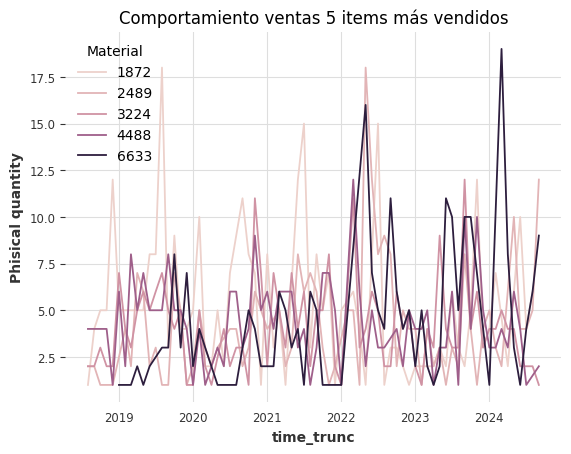

In [96]:
ax = sns.lineplot(data=filtered_df, x='time_trunc', y='Phisical quantity', hue='Material')
ax.set_title('Comportamiento ventas 5 items más vendidos')

In [ ]:
agg_df

In [83]:
serie = TimeSeries.from_series(filtered_df, freq='MS')
serie.plot()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

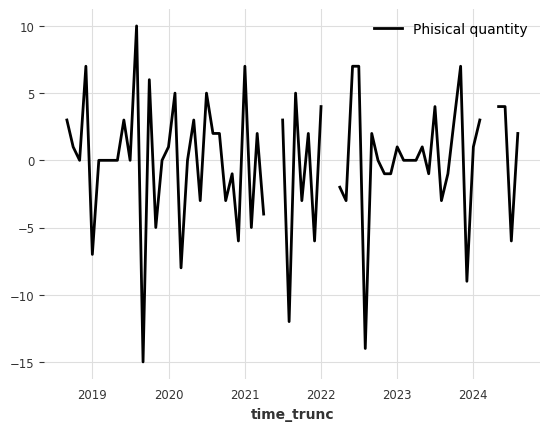

In [37]:
diff_series = serie.diff()
diff_series.plot()
plt.show()

In [38]:
values = serie.pd_series().values
boxcox_values, lambda_value = boxcox(values)
print(f'Lambda: {lambda_value}')

Lambda: 8.472135811722177


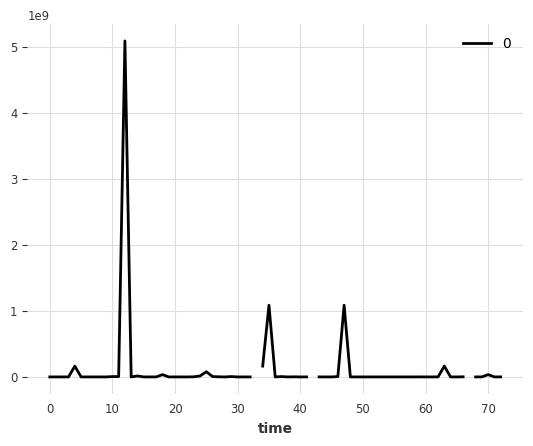

In [39]:
boxcox_series = TimeSeries.from_values(boxcox_values)
boxcox_series.plot()
plt.show()